Rozpoznawanie tweetów dotyczących katastrof
===================================================

Celem zadania jest rozpoznawanie czy dany tweet mówi o katastrofie. Zadnie zostało rozwiązane przy pomocy sicei transformers z wykorzystaniem AdaBoost. Jako pierwsze ładujemy wszystkie konieczne biblioteki i zbiór danych treningowy i testowy.

In [1]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import string
import numpy as np
import re
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium 
from folium import plugins 
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import one_hot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy import array
from sklearn import metrics
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras

train = pd.read_csv('./data/train.csv') # wczytywanie zbioru treningowego
test = pd.read_csv('./data/test.csv') # wczytywanie zbioru testowego

print("Wymiary zbioru: ")
print("Treningowy:  {} x {}".format(train.shape[0], train.shape[1]))
print("Testowy: {} x {}".format(test.shape[0], test.shape[1]))

Wymiary zbioru: 
Treningowy:  7613 x 5
Testowy: 3263 x 4


Nasze dane składają się z lokalizacji danego tweeta, jego tekstu oraz czy mówi on o katastrofie czy nie.

In [2]:
train.head(40)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


Można przy użyciu Pythonowego pakietu geoPy wyświetlić najpopularniejsze lokalizację tweeta. 

In [3]:
new_df = pd.DataFrame() #pomocniczy DataFrame
new_df['location'] = ((train['location'].value_counts())[:50]).index #
new_df['count'] = ((train['location'].value_counts())[:50]).values
geolocator = Nominatim(user_agent = 'UM aplikacja') # wykorzystyjemy geocode z OpenStreetMap
geocode = RateLimiter(geolocator.geocode, min_delay_seconds = 0.5) # ograniczamy tempo zapytań do serwera by nie przekroczyć limitu zapytań na sekundę
lat = {}
long = {}
for i in new_df['location']:
    location = geocode(i)
    lat[i] = location.latitude
    long[i] = location.longitude
new_df['latitude'] = new_df['location'].map(lat)
new_df['longitude'] = new_df['location'].map(long)
map = folium.Map(location = [10.0, 10.0], tiles = 'CartoDB dark_matter', zoom_start = 1.5) #pakiet folium pozwala na stworzenie interaktywenj mapy
markers = []
title = '''<h1 align = "center" style = "font-size: 15px"><b>50 najpopularniejszych lokalizacji tweetów</b></h1>'''
for i, r in new_df.iterrows():
    if r['count'] > 0:
        counts = r['count'] * 0.4
        folium.CircleMarker([float(r['latitude']), float(r['longitude'])], radius = float(counts), color = 'lightcoral', fill = True).add_to(map)
map.get_root().html.add_child(folium.Element(title))
map

Ważny jest rozkład ile danej klasy jest przypadków w naszym zbiorze uczącym. Powinno być ich mniej więcej po równo.

Z katastrofami:49613 Bez katastrof:63848


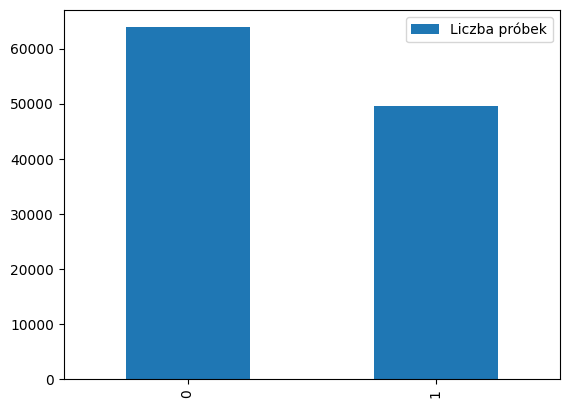

In [4]:
non_disaster = [i for x in train[train['target']==0]['text'].str.split() for i in x]
disaster = [i for x in train[train['target']==1]['text'].str.split() for i in x]
df2 = pd.DataFrame([len(non_disaster),len(disaster)], columns=['Liczba próbek'])
df2.plot(kind='bar')
print("Z katastrofami:"+str(len(disaster))+" Bez katastrof:"+str(len(non_disaster)))

W zbiorze znajdują się znaki interpunkcyjne, znaki specjalne i emotikony, które potencjalnie mogą utrudniać proces wykrywania:

<BarContainer object of 23 artists>

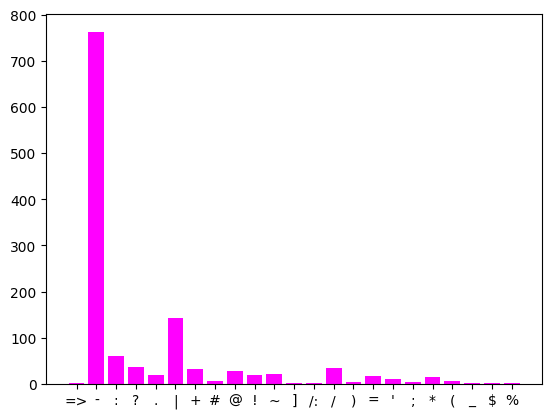

In [5]:
tweet_words=[i for x in train['text'].str.split() for i in x]
dic=defaultdict(int)
special = string.punctuation
for c in (tweet_words):
    if c in special:
        dic[c]+=1
            
x,y=zip(*dic.items())
plt.bar(x,y, color='magenta')

Nalepszym rozwiązaniem jest pozbycie się ich:

In [6]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [7]:
train["text"] = train["text"].apply(lambda x: re.split('https?:\/\/.*', str(x))[0])

In [8]:
train["text"] = train["text"].apply(lambda x: re.sub('[^\w\s]+', '', x))

In [9]:
train["text"] = train["text"].apply(lambda x: re.split("["
                           u"\U0001F600-\U0001F64F"  # emotikony
                           u"\U0001F300-\U0001F5FF"  # inne symbole
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", str(x))[0])

W zbiorze wynikowym nie powinno być np, hashtagów: 

In [10]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1
5,8,NaN,NaN,RockyFire Update California Hwy 20 closed in ...,1
6,10,NaN,NaN,flood disaster Heavy rain causes flash floodin...,1
7,13,NaN,NaN,Im on top of the hill and I can see a fire in ...,1
8,14,NaN,NaN,Theres an emergency evacuation happening now i...,1
9,15,NaN,NaN,Im afraid that the tornado is coming to our area,1


W zbiorze znajduje się wiele słów które nie mają dla nas znaczenia tzw. słowa stop (w angielskim np. the, in of etc.)

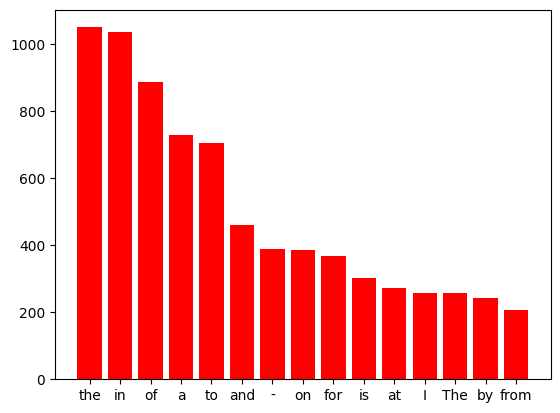

In [11]:
def count_words(tweet_words, color):
    result = pd.value_counts(np.array(tweet_words))
    top15 = result.head(15)
    plt.bar(top15.index, top15.values, color=color)
count_words(disaster, "red")

Za pomocą pakietu do przetwarzania języka naturalnego możemy je usunąć:

In [12]:
nltk.download('stopwords')
nltk.download('punkt')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryszard\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ryszard\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [13]:
def create_corpus(df):
    return [[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))] for tweet in df['text']] 
#usuń słowo jeśli jest w zbiorze słów stopu

In [14]:
corpus=create_corpus(train)
corpus[:5]

[['our', 'deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'],
 ['all',
  'residents',
  'asked',
  'shelter',
  'place',
  'notified',
  'officers',
  'no',
  'evacuation',
  'shelter',
  'place',
  'orders',
  'expected'],
 ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'california'],
 ['just',
  'got',
  'sent',
  'photo',
  'ruby',
  'alaska',
  'smoke',
  'wildfires',
  'pours',
  'school']]

Skorzystaliśmy z zewnętrznego arkusza do wektoryzacji słów. Plik zawiera w każdej linii słowo i odpowiadający mu wektor. Zbiór nie został dodany do plików gdyż waży ponad 2GB. Można pobrać go pod adresem: https://www.kaggle.com/datasets/fullmetal26/glovetwitter27b100dtxt. Został on stworzony specjalnie na potrzeby twittera. Umieszcza on każde słowo w przestrzeni 200 wymiarowej.

In [15]:
embedding_dict={}
i=0
with open('./glove.twitter.27B.200d.txt','r', encoding="utf8") as f:
    for line in f:
        if i<10:
            print(line)
        i=i+1
        words = line.split()
        word = words[0]
        embedding_dict[word] = np.asarray(words[1:],'float32')
f.close()

<user> 0.31553 0.53765 0.10177 0.032553 0.003798 0.015364 -0.20344 0.33294 -0.20886 0.10061 0.30976 0.50015 0.32018 0.13537 0.0087039 0.1911 0.24668 -0.060752 -0.43623 0.019302 0.59972 0.13444 0.012801 -0.54052 0.27387 -1.182 -0.27677 0.11279 0.46596 -0.090685 0.24253 0.15654 -0.23618 0.57694 0.17563 -0.01969 0.018295 0.37569 -0.41984 0.22613 -0.20438 -0.076249 0.40356 0.61582 -0.10064 0.23318 0.22808 0.34576 -0.14627 -0.1988 0.033232 -0.84885 -0.25684 0.26369 0.29562 0.1847 -0.20668 -0.013297 0.12233 -0.47751 -0.17202 -0.14577 0.047446 -0.15824 0.054215 -0.19426 -0.081484 0.099009 0.10159 0.043571 0.50245 0.13362 0.065985 0.032969 -0.2017 -0.56905 -0.13203 0.073347 -0.063728 -0.2796 -0.38481 -0.020193 0.22298 -0.059115 0.045198 -0.13995 -0.13299 0.47309 -0.021874 0.38758 -0.074926 -0.0028093 -0.29829 -0.074987 -0.58542 -0.18065 -0.041805 0.41938 0.41004 -0.5911 0.10459 0.10724 0.69768 -0.15901 -0.059596 0.29368 -0.19609 0.39124 -0.29333 -0.0050833 -0.37854 0.33858 0.24782 0.29144 -0.2

In [16]:
len(embedding_dict.get("disaster"))

200

Dokonaliśmy tokenizacji tweetów.

In [17]:
MAX_LEN = 200
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus) # tworzenie słownika dla naszych tweetów
sequences = tokenizer.texts_to_sequences(corpus) # zamiana tweetów na sekwencję numerów

tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post') #uzupełńienie o padding

In [18]:
word_index = tokenizer.word_index
print('Unique words:', len(word_index))

Unique words: 15540


In [19]:
mat_dim = len(word_index) + 1
embedding_matrix = np.zeros((mat_dim, 200))

for word, i in word_index.items():
    if i > mat_dim:
        continue 
    
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec #przypisujemy wektor słowa do tweeta, który go zawiera

In [20]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.056404  ,  0.49535999,  0.18438999, ...,  0.63598001,
        -0.18880001, -0.035558  ],
       [ 0.49349999,  0.35698   ,  0.66068   , ...,  0.17705999,
        -0.53694999, -0.29699001],
       ...,
       [-0.56013   ,  0.26482999,  0.47959   , ...,  0.39513999,
         0.75584   , -0.65382999],
       [ 0.13251001, -0.28165999,  0.088069  , ...,  0.72741997,
         0.86183   ,  0.046106  ],
       [ 0.47209001, -0.21304999,  0.053563  , ...,  1.10819995,
         0.21586999, -0.32132   ]])

Dzielimy dane na zbiory treningowe i validacyjne

In [21]:
vocab_size = len(word_index)+1  # Rozmiar słownika
num_tokens_per_example = 200  # Maksymalna liczba tokenów w przykładzie
x_train, x_val, y_train, y_val = train_test_split( tweet_pad, train["target"], test_size=0.20, random_state=42)
x_train = x_train[0:6000]
y_train = y_train[0:6000]
x_val = x_val[0:1500]
y_val = y_val[0:1500]
print(tweet_pad.shape, x_train.shape, y_train.shape,x_val.shape, y_val.shape)


(7613, 200) (6000, 200) (6000,) (1500, 200) (1500,)


In [22]:
embed_dim = 200  # Rozmiar wektora pojedynczego słowa
num_heads = 5  # Ilość głowic uwagi
ff_dim = 50  # Liczba neuronów w warstwie ukrytej
num_experts = 8  # Liczb expertów w Przełączniku
batch_size = 100  # Rozmiar batcha
learning_rate = 0.0003  # Learning rate
dropout_rate = 0.5  # Dropout rate
num_epochs = 20  # Liczba epok
num_tokens_per_batch = (
    batch_size * num_tokens_per_example
)  # Liczba tokenów w batchu
print(f"Liczba tokenów w batchu: {num_tokens_per_batch}")

Liczba tokenów w batchu: 20000


Inicjalizacja warstwy embedding. Jako, że jest to sieć transfromers tworzymy też warstwę uwzględniającą pozycję słowa. Teoretcycznie w naszym przypadku może nie mieć to dużego znaczenia ze względu na usunięcie słów stopu, ale postanowiliśmy ją zachować.

In [23]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        global embedding_matrix
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                  trainable=False) #tworzenie warstwy embedding
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim) #tworzenie warstwy uwzględnającej pozycję

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1) #proste kodowanie pozycyjne oparte na zwiększających się numerach
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Nasza sieć będzie klasyfikowała w oparciu o zdania kilku sieci o słabych zdolnościach klasyfikacyjnych (AdaBoost). Każda z nich będzie się składała z 3 warstw gęstych.

In [24]:
def create_feedforward_network(ff_dim, name=None):
    return keras.Sequential(
        [layers.Dense(ff_dim, activation="relu"), layers.Dense(ff_dim, activation="relu"), layers.Dense(ff_dim, activation="relu")], name=name
    )

In [25]:
def load_balanced_loss(router_probs, expert_mask):
    #funkcja licząca startę
    
    num_experts = tf.shape(expert_mask)[-1]
    
    # Wektor mówiący ile tokenów zostało przypisanych do podsieci
    density = tf.reduce_mean(expert_mask, axis=0)
    
    # Wektor szans na przypisanie tokenów do danego wierzchołka
    density_proxy = tf.reduce_mean(router_probs, axis=0)
    
    # Funkcją straty jest iloczyn skalarny powyższych wektorów
    loss = tf.reduce_mean(density_proxy * density) * tf.cast(
        (num_experts ** 2), tf.dtypes.float32
    )
    return loss

In [26]:
class Router(layers.Layer):
    #ta klasa jest odpowiedzialna za przydzielanie tokenów do podsieci
    def __init__(self, num_experts, expert_capacity):
        self.num_experts = num_experts
        self.route = layers.Dense(units=num_experts)
        self.expert_capacity = expert_capacity
        super(Router, self).__init__()

    def call(self, inputs, training=False):
        router_logits = self.route(inputs)

        # Przydzielanie próbek do podsieci (zapisane w formie hot one)
        router_probs = keras.activations.softmax(router_logits, axis=-1)
        expert_gate, expert_index = tf.math.top_k(router_probs, k=1)
        expert_mask = tf.one_hot(expert_index, depth=self.num_experts)
        
        # Obliczanie funkcji straty
        aux_loss = load_balanced_loss(router_probs, expert_mask)
        self.add_loss(aux_loss)
        
        # Rozdział batchy do podsieci
        position_in_expert = tf.cast(
            tf.math.cumsum(expert_mask, axis=0) * expert_mask, tf.dtypes.int32
        )
        
        # Ograniczenie liczby tokenów dla każdej podsieci
        expert_mask *= tf.cast(
            tf.math.less(
                tf.cast(position_in_expert, tf.dtypes.int32), self.expert_capacity
            ),
            tf.dtypes.float32,
        )
        expert_mask_flat = tf.reduce_sum(expert_mask, axis=-1)
        expert_gate *= expert_mask_flat
        
        # Właściwa funkcja AdaBoost - kombinacja liniowa podsieci i prawdopodobieństw
        combined_tensor = tf.expand_dims(
            expert_gate
            * expert_mask_flat
            * tf.squeeze(tf.one_hot(expert_index, depth=self.num_experts), 1),
            -1,
        ) * tf.squeeze(tf.one_hot(position_in_expert, depth=self.expert_capacity), 1)
        dispatch_tensor = tf.cast(combined_tensor, tf.dtypes.float32)

        return dispatch_tensor, combined_tensor

In [27]:
class Switch(layers.Layer):
    def __init__(self, num_experts, embed_dim, num_tokens_per_batch, capacity_factor=1):
        self.num_experts = num_experts
        self.embed_dim = embed_dim
        #tworzymy sieci dla mechanizmu AdaBoost
        self.experts = [
            create_feedforward_network(embed_dim) for _ in range(num_experts)
        ]

        self.expert_capacity = num_tokens_per_batch // self.num_experts
        #tworzymy router
        self.router = Router(self.num_experts, self.expert_capacity)
        super(Switch, self).__init__()

    def call(self, inputs):
        try:
            batch_size = tf.shape(inputs)[0]
            num_tokens_per_example = tf.shape(inputs)[1]
            print(tf.shape(inputs),inputs)
            
            inputs = tf.reshape(inputs, [num_tokens_per_batch, self.embed_dim])
            
            dispatch_tensor, combine_tensor = self.router(inputs)
            
            expert_inputs = tf.einsum("ab,acd->cdb", inputs, dispatch_tensor)
            expert_inputs = tf.reshape(
                expert_inputs, [self.num_experts, self.expert_capacity, self.embed_dim]
            )
            
            # Rozdział danych na podsieci i obliczanie dla nich wyniku
            expert_input_list = tf.unstack(expert_inputs, axis=0)
            expert_output_list = [
                self.experts[idx](expert_input)
                for idx, expert_input in enumerate(expert_input_list)
            ]
            
            expert_outputs = tf.stack(expert_output_list, axis=1)
            expert_outputs_combined = tf.einsum(
                "abc,xba->xc", expert_outputs, combine_tensor
            )
            outputs = tf.reshape(
                expert_outputs_combined,
                [batch_size, num_tokens_per_example, self.embed_dim],
            )
            
            return outputs
        except:
            print("Error")
        return []

In [28]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        # sieć jest oparta na typowym dla transformerów mechanizmie uwagi wielogłowicowej
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim) 
        # sieć zawierająca naszych ekspertów
        self.switch = Switch(num_experts, embed_dim, num_tokens_per_batch)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6) #warstwy normalizacyjne
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate) #warstwy dropout
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.switch(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [29]:
def create_classifier():
    #nasza warstwa transformera
    transformer_block = TransformerBlock(ff_dim, num_heads)

    inputs = layers.Input(shape=(num_tokens_per_example,))
    embedding_layer = TokenAndPositionEmbedding(num_tokens_per_example, vocab_size, embed_dim)
    
    x = embedding_layer(inputs) #warstwa embedding
    x = transformer_block(x) #blok transformerów
    x = layers.GlobalAveragePooling1D()(x) #warstwa poolingowa
    x = layers.Dropout(dropout_rate)(x) #warstwa typu dropout
    x = layers.Dense(ff_dim, activation="relu")(x) #warstwa gęsta
    x = layers.Dropout(dropout_rate)(x) #warstwa dropout
    outputs = layers.Dense(1, activation="sigmoid")(x) #wyjściowa klasyfikacja

    classifier = keras.Model(inputs=inputs, outputs=outputs)
    return classifier

Tworzymy klasyfikator - wykorzystujem optymalizator Adama i krosentropię, jako metrykę bierzemy celność

In [30]:
classifier = create_classifier()
classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

Tensor("transformer_block/switch/Shape_2:0", shape=(3,), dtype=int32) Tensor("transformer_block/layer_normalization/batchnorm/add_1:0", shape=(None, 200, 200), dtype=float32)


Uruchmamiamy proces uczenia wraz z dynamicznym wyświetlaniem wykresów:

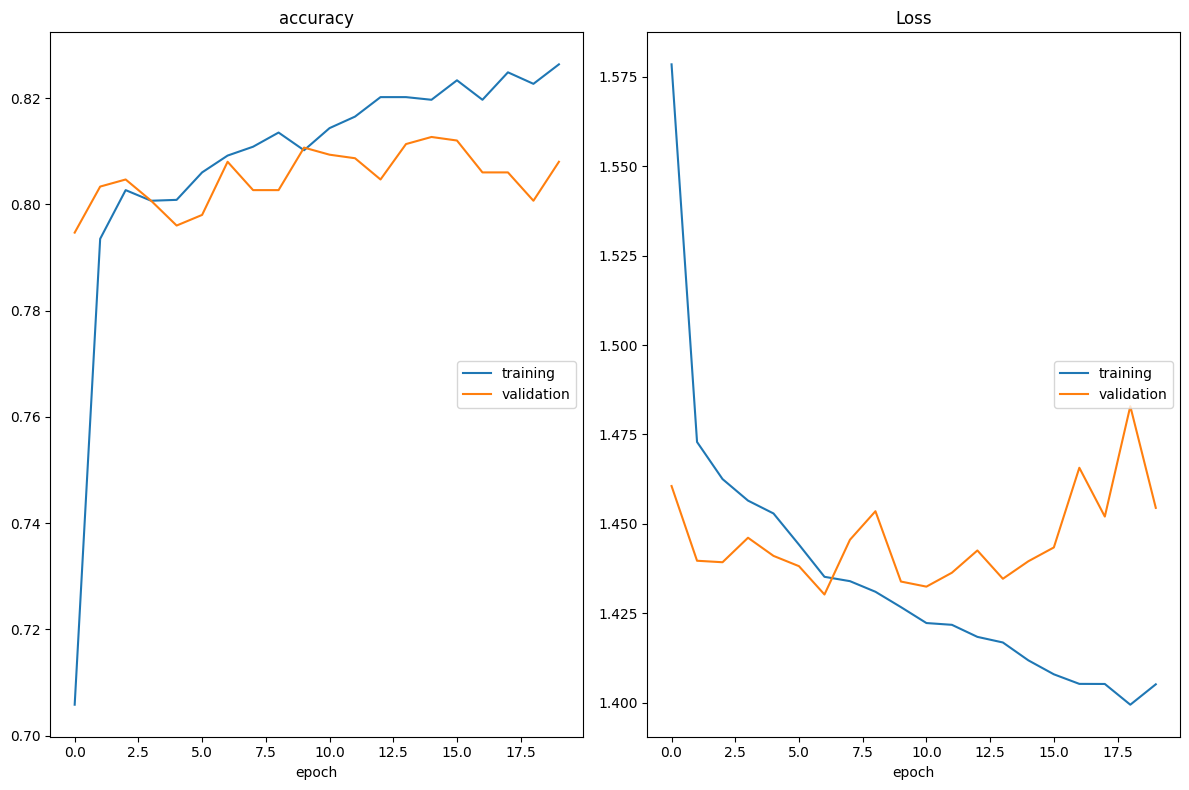

accuracy
	training         	 (min:    0.706, max:    0.826, cur:    0.826)
	validation       	 (min:    0.795, max:    0.813, cur:    0.808)
Loss
	training         	 (min:    1.399, max:    1.578, cur:    1.405)
	validation       	 (min:    1.430, max:    1.483, cur:    1.454)
60/60 [==============================] - 345s 6s/step - loss: 1.4052 - accuracy: 0.8263 - val_loss: 1.4545 - val_accuracy: 0.8080


In [31]:
print( x_train.shape,
        y_train.shape,x_val.shape, y_val.shape)

def run_experiment(classifier):
    history = classifier.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[PlotLossesKeras()],
    )
    return history



run_experiment(classifier)

Uzyskujemy dokładność rzędu 80%:

In [63]:
results = classifier.evaluate(x_val, y_val, batch_size=batch_size)

15/15 [==============================] - 27s 2s/step - loss: 1.4545 - accuracy: 0.8080


In [68]:
y_test=classifier.predict(x_val,batch_size=batch_size)

15/15 [==============================] - 27s 2s/step


Możemy sobie wyświetlić macierz pomyłek, żeby zobaczyć jak wygląda rozkład klasyfikacji:

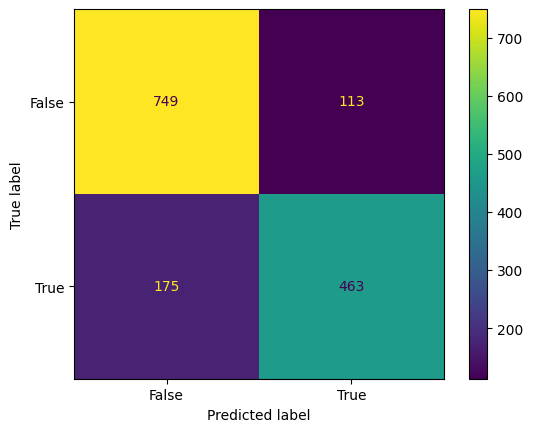

In [71]:
confusion_matrix = metrics.confusion_matrix(y_val, np.where(y_test<=0.5,0,1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()